# OPM Flow Simulation Results Viewer

This notebook helps you visualize results from OPM Flow simulations.
Just update the `results_dir` path below and run all cells (Run → Run All Cells).

In [13]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

# List available result sets (sorted by modification time, newest last)
results_base = '../results/'
result_dirs = sorted(glob.glob(os.path.join(results_base, '*/')), key=os.path.getmtime)
print('Available results:')
for i, d in enumerate(result_dirs):
    print(f'  [{i}] {os.path.basename(d.rstrip("/"))}')
print()
if result_dirs:
    print(f'Latest: {result_dirs[-1]}')

Available results:
  [0] WATERSHED-20260220-005549
  [1] WATERSHED-20260220-005615
  [2] WATERSHED-20260220-010034

Latest: ../results/WATERSHED-20260220-010034/


In [14]:
# ═══════════════════════════════════════════════════
# SET THIS to the result folder you want to plot
# Copy one of the paths printed above
# ═══════════════════════════════════════════════════

# Auto-select the most recent folder that actually contains results
results_dir = None
for d in reversed(result_dirs):
    if glob.glob(os.path.join(d, '*.SMSPEC')):
        results_dir = d
        break

if results_dir is None:
    raise FileNotFoundError('No results folders contain .SMSPEC files. Run a simulation first!')

# Load summary data
from resdata.summary import Summary

smspec_files = glob.glob(os.path.join(results_dir, '*.SMSPEC'))
summary = Summary(smspec_files[0])
print(f'Loaded: {smspec_files[0]}')
print(f'Time range: {summary.dates[0]} → {summary.dates[-1]}')
print(f'Available keys ({len(list(summary.keys()))}): {list(summary.keys())[:20]}...')

Loaded: ../results/WATERSHED-20260220-010034/WATERSHED.SMSPEC
Time range: 2025-01-02 00:00:00 → 2025-02-01 00:00:00
Available keys (47): ['BPR:5,5,2', 'BPR:5,15,2', 'BPR:10,10,2', 'BPR:15,18,2', 'BPR:485', 'BPR:590', 'BPR:685', 'BPR:755', 'FOPR', 'FOPT', 'FPR', 'FWCT', 'FWIR', 'FWIT', 'FWPR', 'FWPT', 'WBHP:RCH1', 'WBHP:RCH2', 'WBHP:RCH3', 'WBHP:RCH4']...


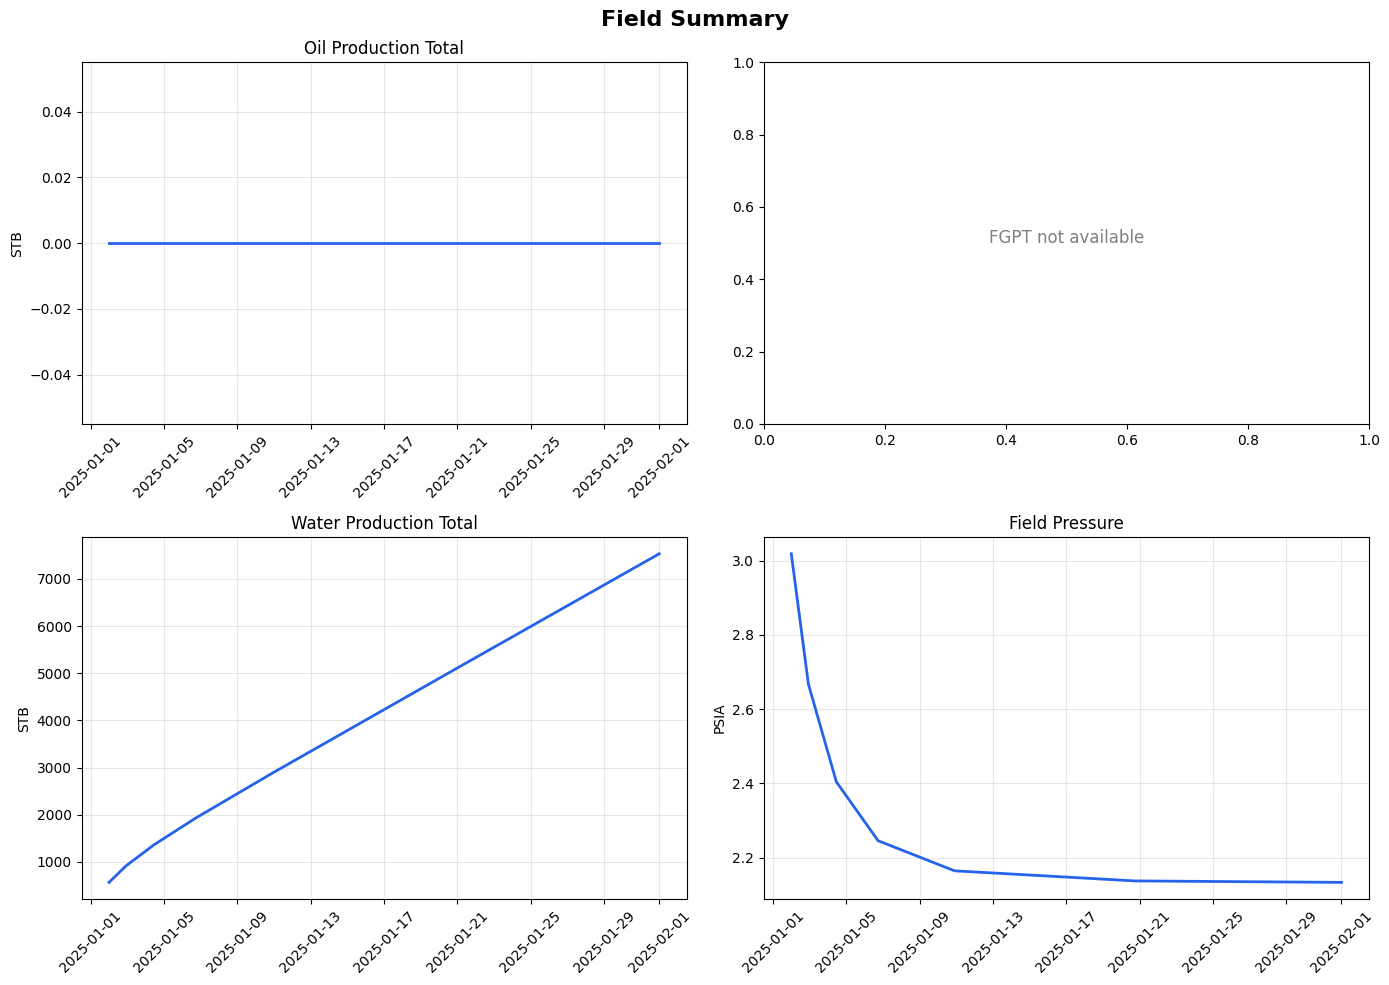

In [15]:
# ═══════════════════════════════════════════════════
# Field Overview — Production and Pressure
# ═══════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Field Summary', fontsize=16, fontweight='bold')

plots = [
    ('FOPT', 'Oil Production Total', 'STB'),
    ('FGPT', 'Gas Production Total', 'MSCF'),
    ('FWPT', 'Water Production Total', 'STB'),
    ('FPR',  'Field Pressure', 'PSIA'),
]

for ax, (key, title, unit) in zip(axes.flat, plots):
    try:
        values = summary.numpy_vector(key)
        ax.plot(summary.dates, values, linewidth=2, color='#2563eb')
        ax.set_title(title)
        ax.set_ylabel(unit)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    except KeyError:
        ax.text(0.5, 0.5, f'{key} not available', transform=ax.transAxes, ha='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

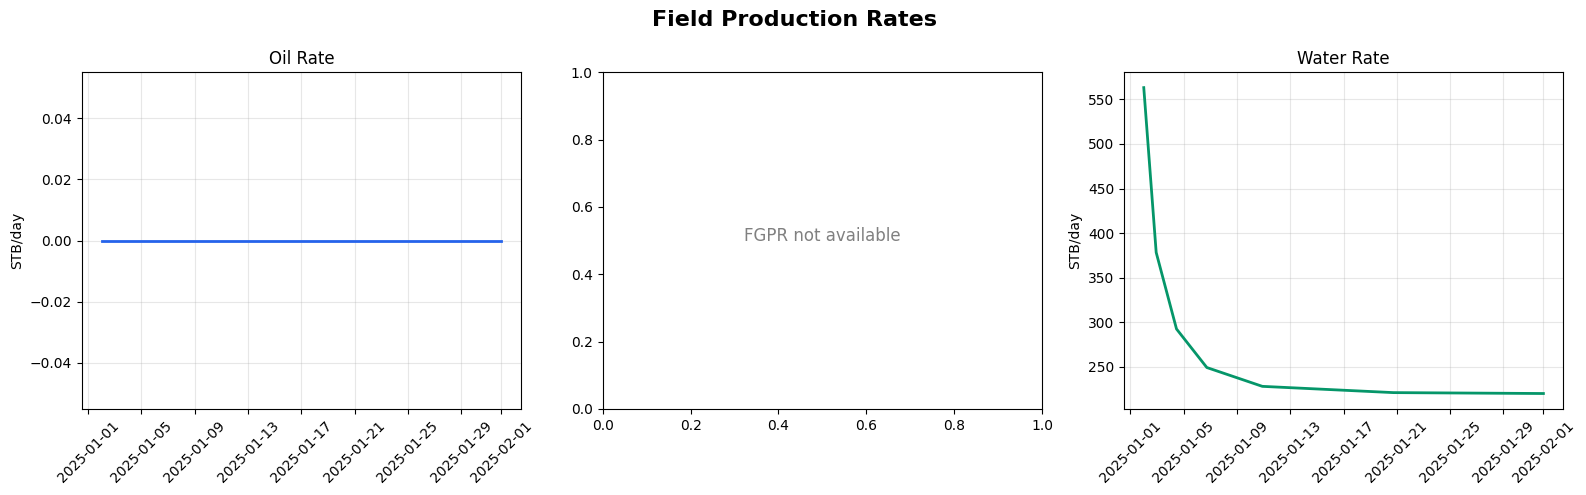

In [16]:
# ═══════════════════════════════════════════════════
# Field Rates (per timestep, not cumulative)
# ═══════════════════════════════════════════════════
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Field Production Rates', fontsize=16, fontweight='bold')

rate_plots = [
    ('FOPR', 'Oil Rate', 'STB/day', '#2563eb'),
    ('FGPR', 'Gas Rate', 'MSCF/day', '#dc2626'),
    ('FWPR', 'Water Rate', 'STB/day', '#059669'),
]

for ax, (key, title, unit, color) in zip(axes.flat, rate_plots):
    try:
        values = summary.numpy_vector(key)
        ax.plot(summary.dates, values, linewidth=2, color=color)
        ax.set_title(title)
        ax.set_ylabel(unit)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    except KeyError:
        ax.text(0.5, 0.5, f'{key} not available', transform=ax.transAxes, ha='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

/tmp/ipykernel_56686/679972548.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


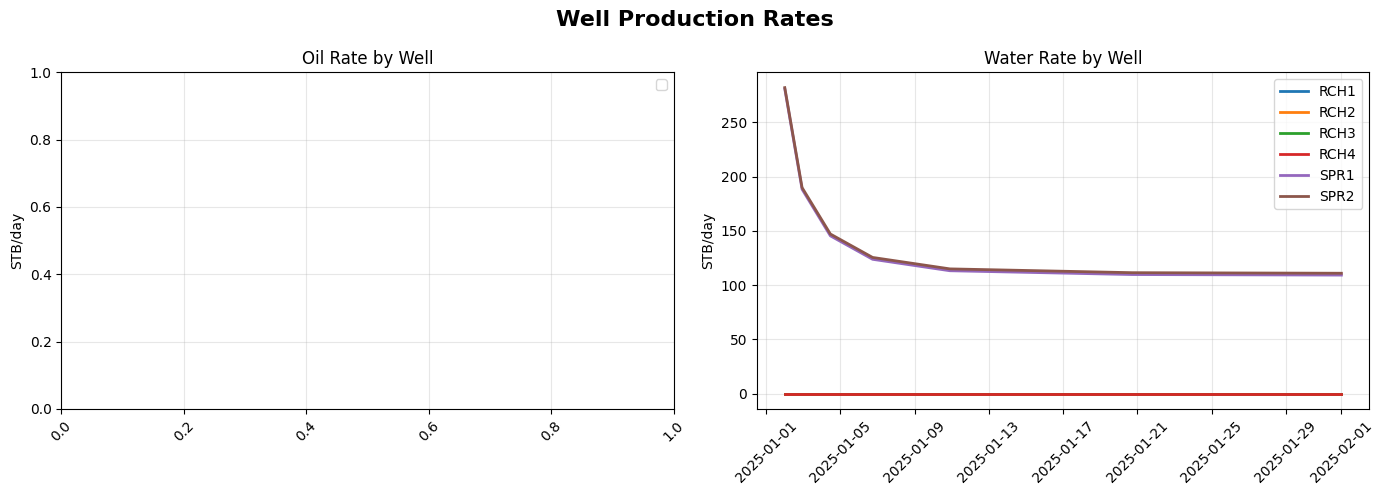

In [17]:
# ═══════════════════════════════════════════════════
# Well Production Rates
# ═══════════════════════════════════════════════════
well_oil_keys = sorted([k for k in summary.keys() if k.startswith('WOPR:')])
well_water_keys = sorted([k for k in summary.keys() if k.startswith('WWPR:')])

if well_oil_keys or well_water_keys:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Well Production Rates', fontsize=16, fontweight='bold')
    
    for key in well_oil_keys:
        well_name = key.split(':')[1]
        axes[0].plot(summary.dates, summary.numpy_vector(key), linewidth=2, label=well_name)
    axes[0].set_title('Oil Rate by Well')
    axes[0].set_ylabel('STB/day')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    for key in well_water_keys:
        well_name = key.split(':')[1]
        axes[1].plot(summary.dates, summary.numpy_vector(key), linewidth=2, label=well_name)
    axes[1].set_title('Water Rate by Well')
    axes[1].set_ylabel('STB/day')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print('No well production keys found in summary data.')

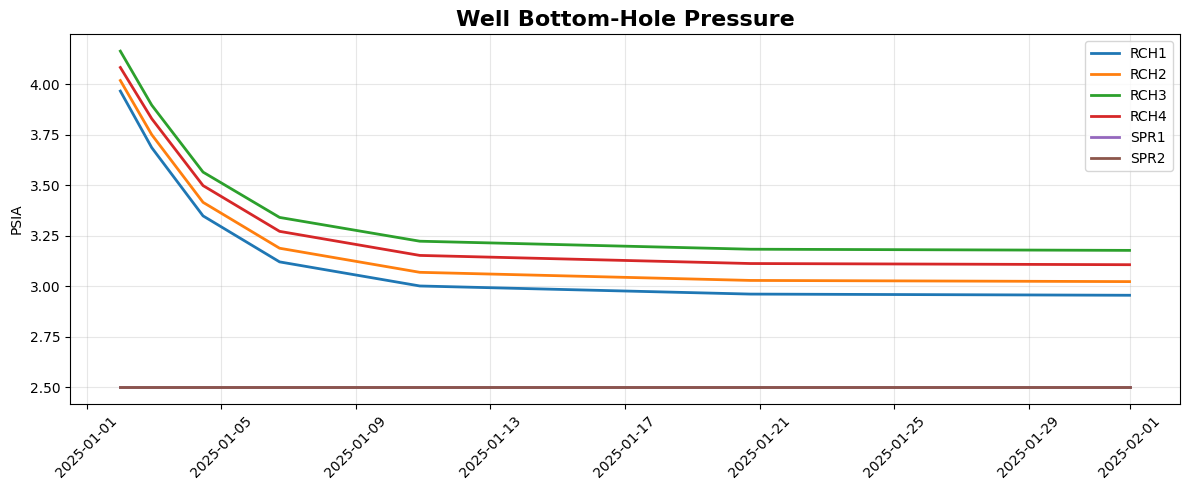

In [18]:
# ═══════════════════════════════════════════════════
# Well Bottom-Hole Pressure
# ═══════════════════════════════════════════════════
wbhp_keys = sorted([k for k in summary.keys() if k.startswith('WBHP:')])

if wbhp_keys:
    fig, ax = plt.subplots(figsize=(12, 5))
    for key in wbhp_keys:
        well_name = key.split(':')[1]
        ax.plot(summary.dates, summary.numpy_vector(key), linewidth=2, label=well_name)
    ax.set_title('Well Bottom-Hole Pressure', fontsize=16, fontweight='bold')
    ax.set_ylabel('PSIA')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No WBHP keys found in summary data.')

In [19]:
# ═══════════════════════════════════════════════════
# All Available Summary Keys (reference)
# ═══════════════════════════════════════════════════
all_keys = sorted(summary.keys())
print(f'Total keys: {len(all_keys)}\n')
for key in all_keys:
    print(f'  {key}')

Total keys: 47

  BPR:10,10,2
  BPR:15,18,2
  BPR:485
  BPR:5,15,2
  BPR:5,5,2
  BPR:590
  BPR:685
  BPR:755
  FOPR
  FOPT
  FPR
  FWCT
  FWIR
  FWIT
  FWPR
  FWPT
  WBHP:RCH1
  WBHP:RCH2
  WBHP:RCH3
  WBHP:RCH4
  WBHP:SPR1
  WBHP:SPR2
  WWIR:RCH1
  WWIR:RCH2
  WWIR:RCH3
  WWIR:RCH4
  WWIR:SPR1
  WWIR:SPR2
  WWIT:RCH1
  WWIT:RCH2
  WWIT:RCH3
  WWIT:RCH4
  WWIT:SPR1
  WWIT:SPR2
  WWPR:RCH1
  WWPR:RCH2
  WWPR:RCH3
  WWPR:RCH4
  WWPR:SPR1
  WWPR:SPR2
  WWPT:RCH1
  WWPT:RCH2
  WWPT:RCH3
  WWPT:RCH4
  WWPT:SPR1
  WWPT:SPR2
  YEARS
